In [1]:
suppressPackageStartupMessages({
    library(tidyverse);
    library(stringr);
    library(magrittr);
    library(modelr);
    library(broom);
    library(purrr)
})

source("../R/utils.R")

Conflicts with tidy packages ---------------------------------------------------


## Load the conservation tracks

### Window averages

In [2]:
files <- list.files("../clean_data/annotations", pattern="*.bed$", full.names=TRUE)

window_avgs_long <- lapply(files, function(f) {
    read.table(f, header=FALSE) %>%
        .[1:4] %>%
        setNames(c("chrom", "start", "end", "value")) %>%
        mutate(track=str_replace(basename(f), ".bed", ""))
}) %>%
    bind_rows %>%
    rename(pos=end) %>% 
    select(-start)

window_avgs_wide <- spread(window_avgs_long, track, value)

### Load a subset of annotation tracks used by CADD

In [3]:
suppressMessages(
    cadd_wide <-
        load_annotations("../clean_data/annotations.tsv") %>%
        select(chrom, pos, bStatistic, Consequence, AnnoType)
)

Warning message:
"673 parsing failures.
 row            col               expected  actual
2136 mapAbility35bp no trailing characters .5     
4607 mapAbility35bp no trailing characters .333333
5028 mapAbility35bp no trailing characters .5     
5379 mapAbility35bp no trailing characters .5     
5819 mapAbility35bp no trailing characters .5     
.... .............. ...................... .......
See problems(...) for more details.
"

### Merge both annotation data sets (homemade window-based and CADD subset)

In [4]:
all_annots_wide <- inner_join(window_avgs_wide, cadd_wide)

Joining, by = c("chrom", "pos")


In [5]:
colnames(all_annots_wide)[3:ncol(all_annots_wide)]

[1] "bval__100000bp"           "bval__10000bp"           
 [3] "bval__25000bp"            "bval__50000bp"           
 [5] "exon_density__100000bp"   "exon_density__10000bp"   
 [7] "exon_density__25000bp"    "exon_density__50000bp"   
 [9] "exon_distance"            "phyloP_nohuman__100000bp"
[11] "phyloP_nohuman__10000bp"  "phyloP_nohuman__25000bp" 
[13] "phyloP_nohuman__50000bp"  "priPhCons__100000bp"     
[15] "priPhCons__10000bp"       "priPhCons__25000bp"      
[17] "priPhCons__50000bp"       "priPhyloP__100000bp"     
[19] "priPhyloP__10000bp"       "priPhyloP__25000bp"      
[21] "priPhyloP__50000bp"       "bStatistic"              
[23] "Consequence"              "AnnoType"

## Load the SNP data

In [6]:
suppressMessages({

# read processed SNP tables of aDNA samples and SGDP individuals,
# merge them and intersect them with the annotations data
all_snps <- load_dataset("../clean_data/ice_age.tsv",
                       "../clean_data/sgdp.tsv",
                       "../clean_data/archaics.tsv",
                       filter_damage=TRUE, # remove potential aDNA substitutions (C->T, G->A)
                       metadata_path="../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>%
    inner_join(all_annots_wide)

# process the SGDP metainformation table
sgdp_info <-
  load_sgdp_info("../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>%
  mutate(name=str_replace(name, "^S_", "")) %>%
  filter(name %in% colnames(all_snps)) %>%
  mutate(age=0) %>%
  rename(pop=Region) %>%
  filter(!(pop == "Oceania" & Country != "PapuaNewGuinea")) %>%
  mutate(pop=ifelse(pop == "Oceania", "Papuan", pop)) %>%
  filter(pop != "Papuan")

emh_info <-
  read_delim("../clean_data/ages.txt", delim=" ") %>%
  mutate(pop="EMH") %>%
  filter(name %in% colnames(all_snps),
         ! name %in% c("Continenza", "Kostenki12", "Ostuni2",
                       "Pavlov1", "Vestonice15", "Vestonice43",
                       "Vestonice13", "Oase1", "Muierii2",
                       "AfontovaGora2"))

samples_info <-
  bind_rows(emh_info, sgdp_info) %>%
  mutate(post_admixture=55000 - age,
         name=factor(name, levels=name),
         pop=as.factor(pop))

})

Warning message:
"Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]"Warning message in one_of(sgdp_info$name):
"Unknown variables: `S_Australian_1`, `S_Australian_5`"Warning message:
"Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]"

## Specify conserved/neutral annotation bins

In [7]:
quantile(all_snps$bval__100000bp, probs=c(0.1, 0.9), na.rm=TRUE)

10%      90% 
505.5792 970.8518

Warning message:
"Removed 14 rows containing non-finite values (stat_bin)."

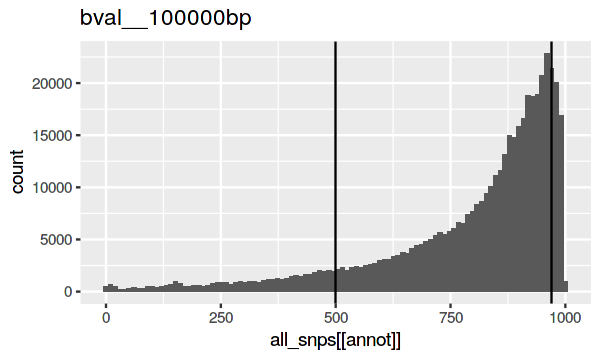

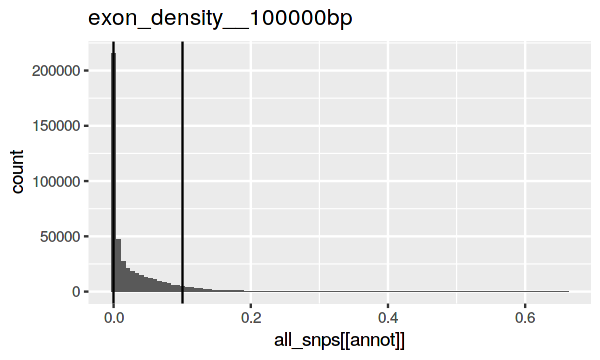

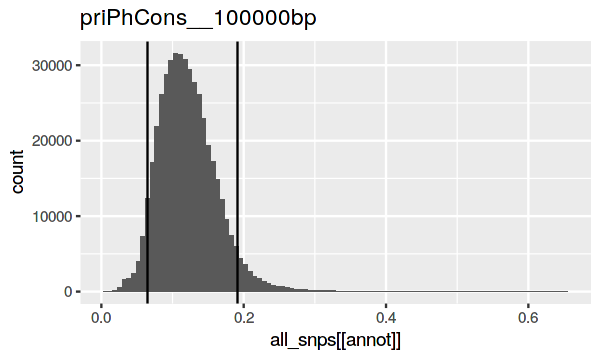

In [8]:
options(repr.plot.width=5, repr.plot.height=3)

plot_annot <- function(annot, low, high) {
  qplot(all_snps[[annot]], bins=100) +
      geom_vline(xintercept=c(low, high)) +
      ggtitle(annot)
}

# specify lower and upper cut-offs for conserved and neutral regions
qs <- quantile(all_snps$priPhCons__100000bp, probs=c(0.05, 0.95), na.rm=TRUE)

b_100k_low          <- 500;   b_100k_high       <- 970
density_100k_low    <- 0;     density_100k_high <- 0.1
priPhCons__100k_low <- qs[1]; priPhCons__100k_high <- qs[2]

# plot the distributions and the cut-off values
plot_annot("bval__100000bp",         b_100k_low,            b_100k_high)
plot_annot("exon_density__100000bp", density_100k_low, density_100k_high)
plot_annot("priPhCons__100000bp", priPhCons__100k_low, priPhCons__100k_high)

## Divide SNPs into conserved/neutral bins based on different annotations

In [9]:
#
# Divide SNPs into two equal-sized bins (conserved and neutral)based
# on the given annotation.
#
bin_cons_neutral <- function(snps, stat,
                           low_cutoff, high_cutoff,
                           low_bin, high_bin, equalize=FALSE) {
  bins <- ifelse(snps[[stat]] <= low_cutoff, low_bin,
          ifelse(snps[[stat]] > high_cutoff, high_bin, NA))

  if (equalize) {
      # count the number of conserved and neutral elements
      counts <- table(bins)

      # get the bin with the highest number of snps
      max_bin <- names(counts)[which(counts == max(counts))]

      # make the counts of bin elements equal by removing a subset
      # of elements from the biggest of the two bins
      bins[sample(which(bins == max_bin), max(counts) - min(counts))] <- NA
  }

  factor(bins)
}

all_snps <-
  mutate(all_snps, # convert annotation types into numeric values for later binning
     genic=ifelse(AnnoType %in% c("CodingTranscript", "RegulatoryFeature"), 1,
           ifelse(AnnoType == "Intergenic", -1, NA)),
     coding=ifelse(AnnoType == "CodingTranscript", 1,
                   ifelse(AnnoType == "Intergenic", -1, NA))
     ) %>% 
  mutate( # bin SNPs into conserved/neutral regions based on different annotations
     annot_bval_100k =     bin_cons_neutral(., "bval__100000bp",          b_100k_low,          b_100k_high,          "conserved", "neutral"),
     annot_genic=          bin_cons_neutral(., "genic",                   -1,                  0,                    "neutral",   "conserved"),
     annot_coding=         bin_cons_neutral(., "coding",                  -1,                  0,                    "neutral",   "conserved"),
     annot_priPhCons_100k= bin_cons_neutral(., "priPhCons__100000bp",     priPhCons__100k_low, priPhCons__100k_high, "neutral",   "conserved"),
     annot_density_100k=   bin_cons_neutral(., "exon_density__100000bp",  density_100k_low,    density_100k_high,    "neutral",   "conserved"))

binned <- gather(all_snps, annot, region, starts_with("annot_")) %>%
  mutate(annot=str_replace(annot, "annot_", ""))

## Number of SNPs available for each annotation bin

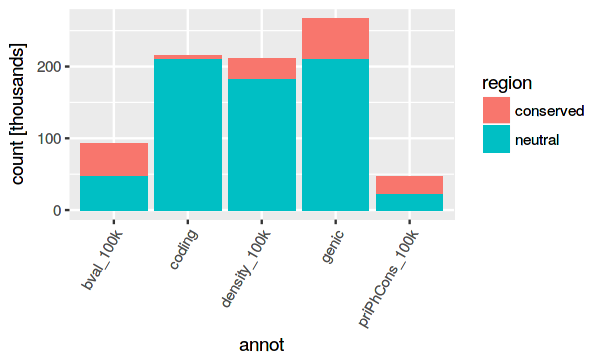

In [10]:
binned %>%
    group_by(annot, region) %>%
    filter(region != "NA") %>%
    summarise(count=n() / 1000) %>% 
    ggplot(aes(annot, count, fill=region)) +
        geom_bar(stat="identity") +
        labs(y="count [thousands]") +
        theme(axis.text.x=element_text(angle=60, hjust=1))

## Calculate Nea% in each conserved/neutral bin for all annotations

In [11]:
nea_cn <-
    samples_info %>%
    filter(pop != "Africa") %>%
    mutate(cons_vs_neutral=purrr::map(as.character(name), function(n) {
        select_(binned, "archaic_Altai", n, "annot", "region") %>%
            group_by(annot, region) %>%
            do(nea=calc_sharing_prop(., "archaic_Altai", n)) %>%
            unnest %>%
            filter(complete.cases(.))
    })) %>% 
    mutate(genome_wide=sapply(as.character(name), function(n) {
        calc_sharing_prop(all_snps, "archaic_Altai", n)
    }))

## Ratios of Nea% in the most conserved vs most neutral regions

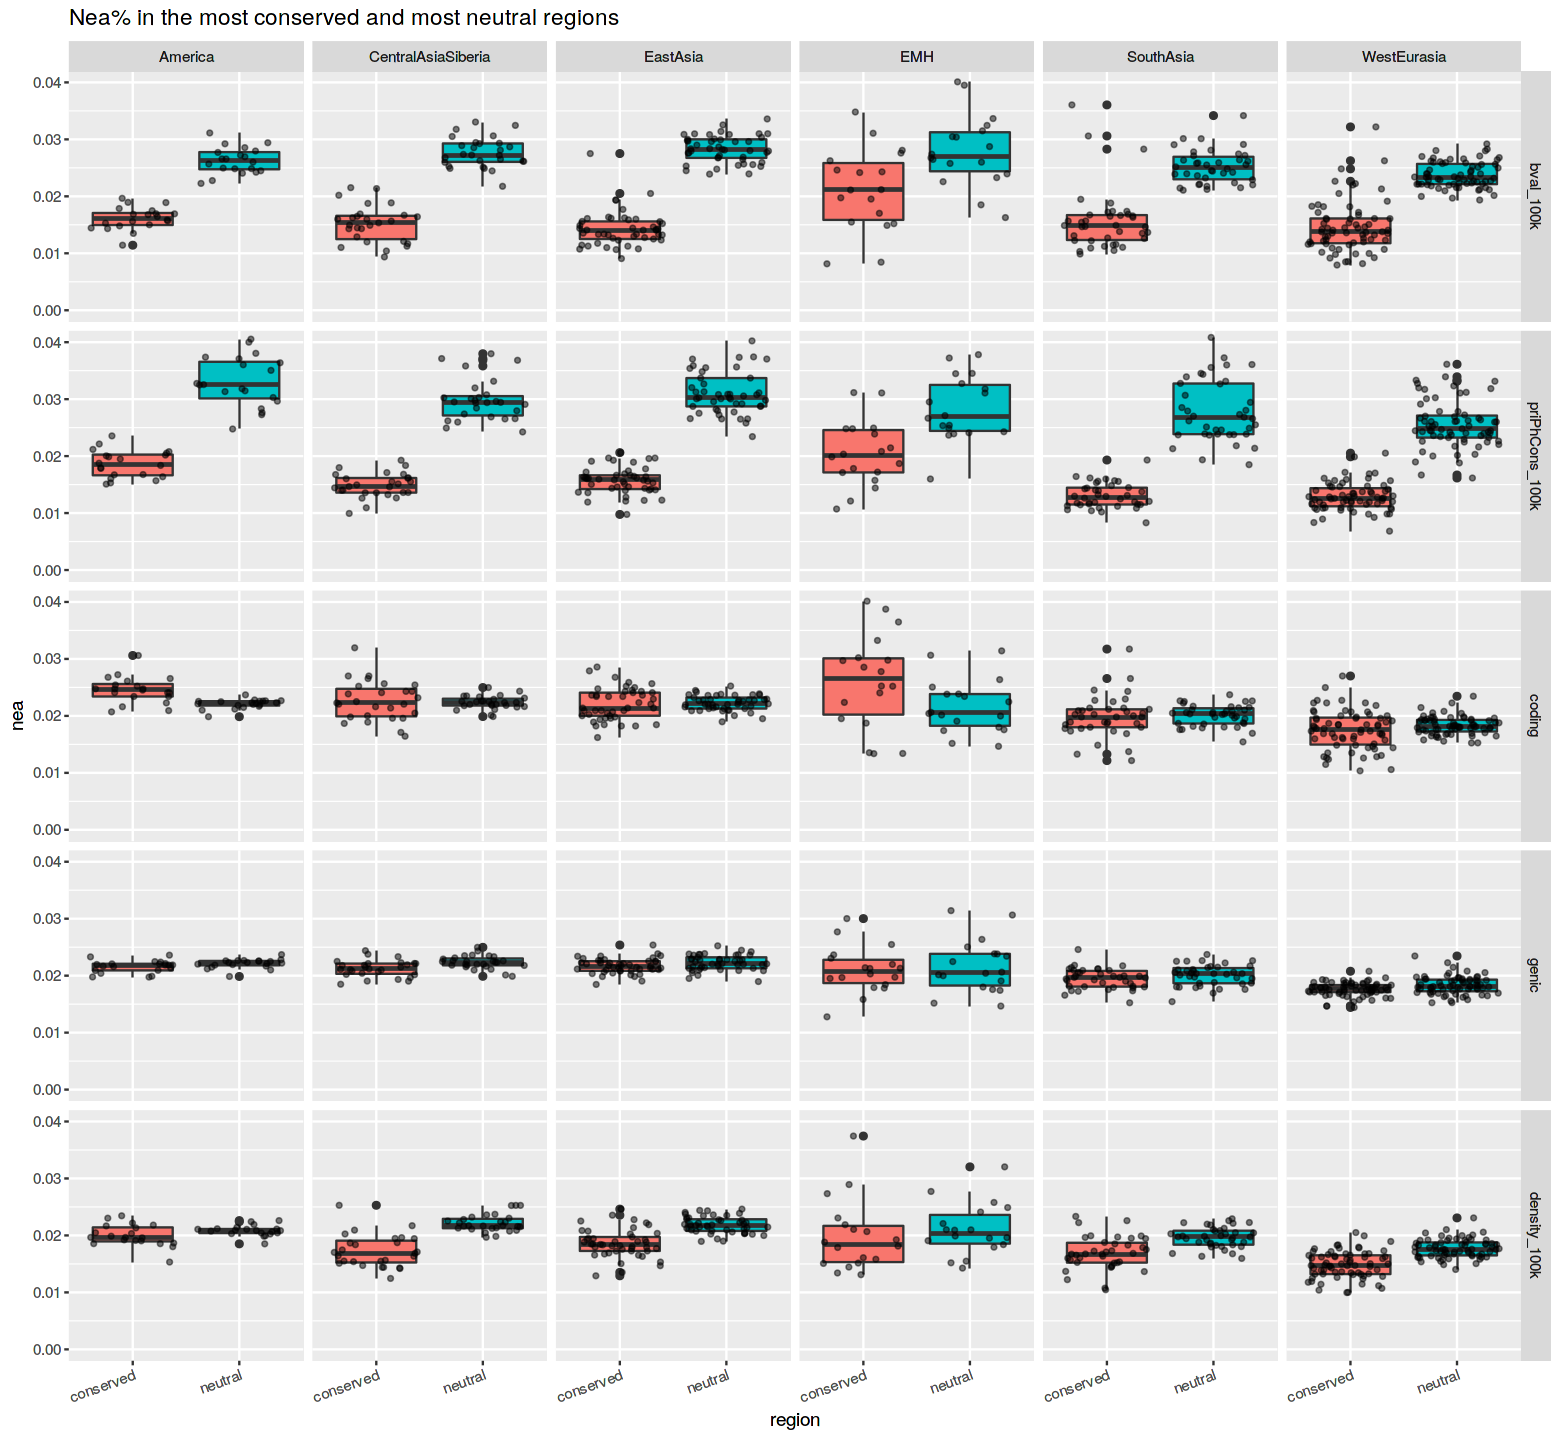

In [12]:
options(repr.plot.width=13, repr.plot.height=12)

unnest(nea_cn) %>%
  mutate(annot=factor(annot, levels=c("bval_100k", "priPhCons_100k", "coding", "genic", "density_100k"))) %>%
  ggplot(aes(region, nea, fill=region)) +
  geom_boxplot() +
  facet_grid(annot ~ pop) +
  geom_jitter(alpha=1/2, size=1) +
  ggtitle("Nea% in the most conserved and most neutral regions") +
  coord_cartesian(ylim=c(0, 0.04)) +
  theme(axis.text.x=element_text(angle=20, hjust=1), legend.position="none")

Does diffferent Nea% in superneutral regions indicate different amounts of Nea. admixture?

## T-test of distribution of Nea% in conserved vs neutral regions

## Nea% vs time in conserved/neutral regions

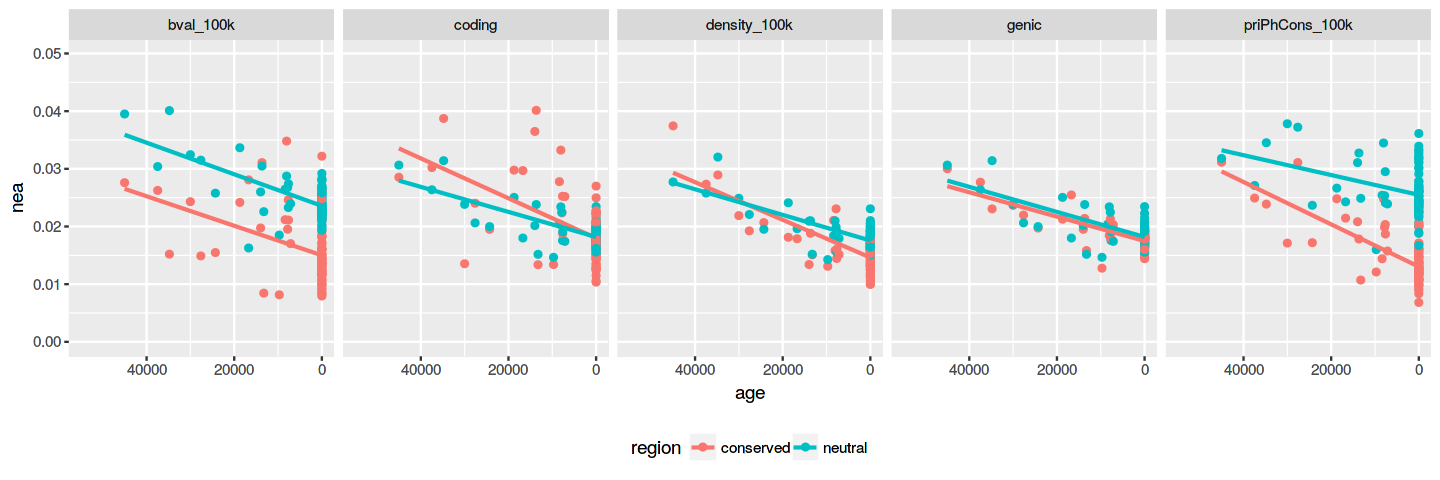

In [13]:
options(repr.plot.width=12, repr.plot.height=4)

nea_cn %>%
  filter(pop %in% c("EMH", "WestEurasia")) %>%
  unnest %>%
  ggplot(aes(age, nea, color=region)) +
  geom_point() +
  geom_smooth(method="lm", se=FALSE, size=0.9) +
  facet_grid(. ~ annot) +
  ylim(0, 0.05) + xlim(55000, 0) +
  theme(legend.position="bottom")

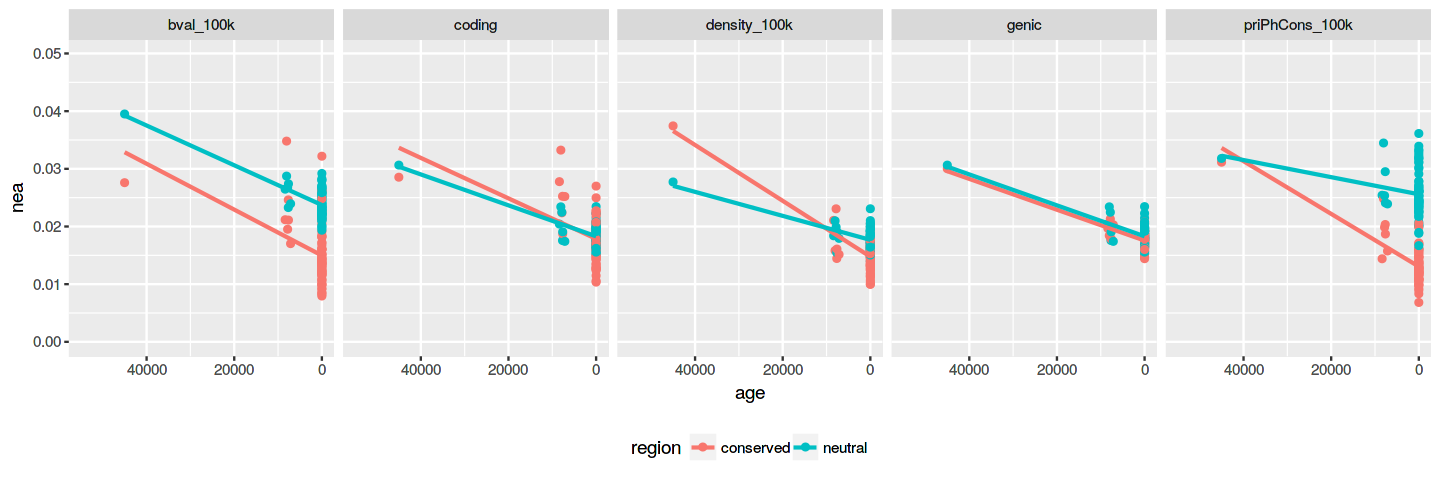

In [14]:
options(repr.plot.width=12, repr.plot.height=4)

nea_cn %>%
  filter(pop %in% c("EMH", "WestEurasia"), age < 9000 | age > 44000) %>%
  unnest %>%
  ggplot(aes(age, nea, color=region)) +
  geom_point() +
  geom_smooth(method="lm", se=FALSE, size=0.9) +
  facet_grid(. ~ annot) +
  ylim(0, 0.05) + xlim(55000, 0) +
  theme(legend.position="bottom")

## Super-neutral stuff

Include only SNPs which:

* have 0% overlap with exons in the 100kb window around the SNP
* phastCons < 0.05 (probability of being in a conserved regions < 5%)
* B value > 950

In [15]:
superneutral_snps <- filter(all_snps,
                            #bval__100000bp > b_100k_high,
                            priPhCons__100000bp < priPhCons__100k_low)

cat("SNPs in the superneutral regions: ", nrow(superneutral_snps), "\n")
cat("Proportion of these SNPs out of all available SNPs: ", nrow(superneutral_snps) / nrow(all_snps))

SNPs in the superneutral regions:  23146 
Proportion of these SNPs out of all available SNPs:  0.0499973

In [16]:
superneutral_vs_all <- nea_cn %>%
    mutate(superneutral=sapply(as.character(name), function(n) { calc_sharing_prop(superneutral_snps, "archaic_Altai", n)})) %>% 
    select(name, age, pop, superneutral, all=genome_wide) %>%
    gather(snps, value, -c(name, age, pop))

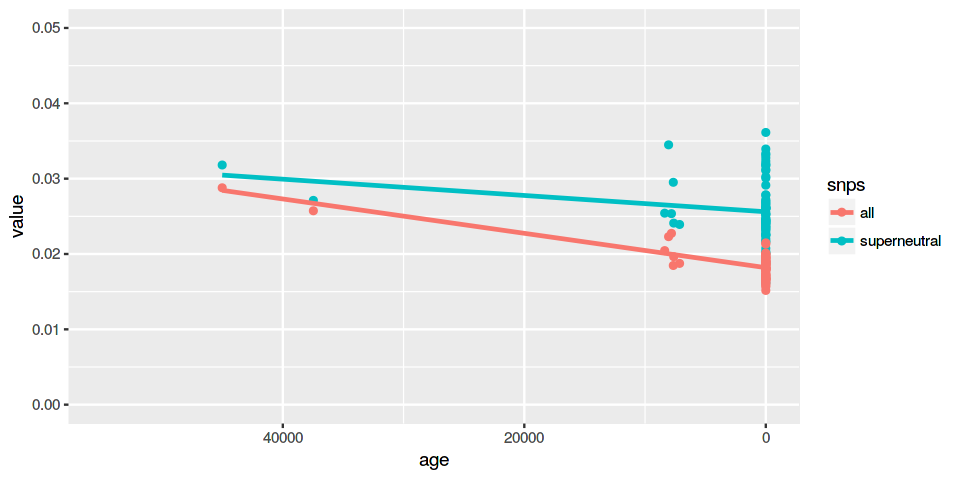

In [17]:
options(repr.plot.width=8, repr.plot.height=4)

filter(superneutral_vs_all, pop %in% c("EMH", "WestEurasia"), age < 9000 | age > 35000) %>% 
ggplot(aes(age, value, color=snps)) +
    geom_point() +
    geom_smooth(method="lm", se=FALSE) +
    ylim(0, 0.05) +
    xlim(55000, 0)

In [110]:
all_snps %>% head

chrom,pos,ref,alt,AfontovaGora2,AfontovaGora3,Continenza,Vestonice13,Vestonice15,Vestonice16,⋯,bStatistic,Consequence,AnnoType,genic,coding,annot_bval_100k,annot_genic,annot_coding,annot_priPhCons_100k,annot_density_100k
1,847983,C,T,NA,NA,NA,NA,NA,NA,,958,NONCODING_CHANGE,NonCodingTranscript,NA,NA,NA,NA,NA,neutral,NA
1,853089,G,C,NA,NA,NA,NA,NA,NA,,958,NONCODING_CHANGE,NonCodingTranscript,NA,NA,NA,NA,NA,neutral,NA
1,853596,A,G,NA,0,NA,NA,NA,NA,,958,NONCODING_CHANGE,NonCodingTranscript,NA,NA,NA,NA,NA,neutral,NA
1,854793,A,C,NA,NA,NA,NA,NA,NA,,958,NONCODING_CHANGE,NonCodingTranscript,NA,NA,NA,NA,NA,neutral,NA
1,867552,T,G,NA,NA,NA,NA,NA,NA,,946,UPSTREAM,Intergenic,-1,-1,NA,neutral,neutral,neutral,conserved
1,871401,A,G,NA,NA,NA,NA,NA,NA,,946,REGULATORY,RegulatoryFeature,1,NA,NA,conserved,NA,neutral,conserved


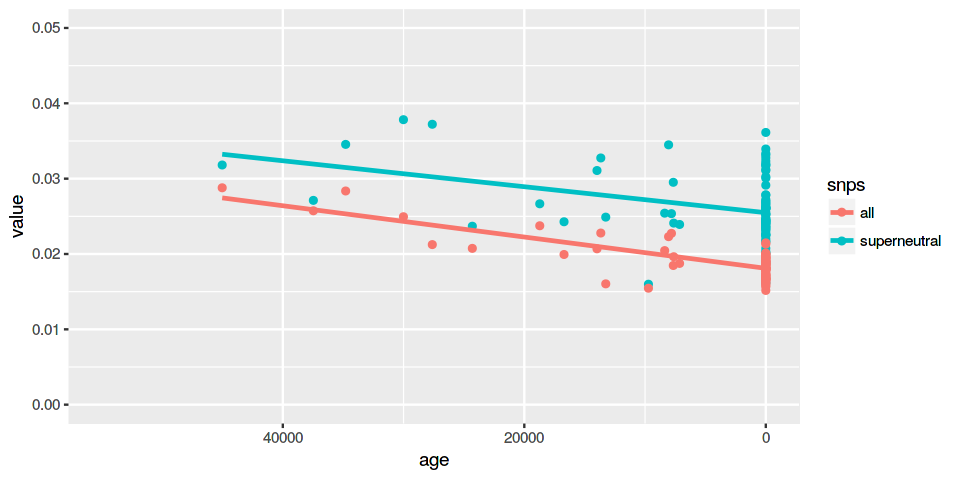

In [18]:
options(repr.plot.width=8, repr.plot.height=4)

filter(superneutral_vs_all, pop %in% c("EMH", "WestEurasia")) %>% 
ggplot(aes(age, value, color=snps)) +
    geom_point() +
    geom_smooth(method="lm", se=FALSE) +
    ylim(0, 0.05) +
    xlim(55000, 0)

## Linear regression - B values

### Calculate Nea% per bin

Warning message:
"Removed 140 rows containing non-finite values (stat_bin)."

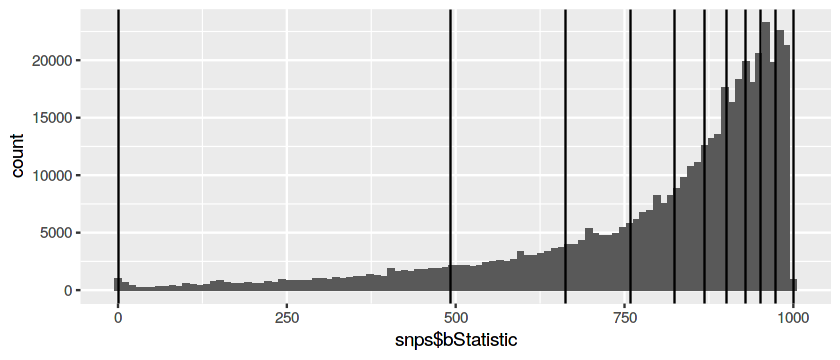

In [19]:
# B values
n_bins <- 10
cutoffs <- quantile(all_snps$bStatistic,
             prob=seq(0, 1, length.out=n_bins + 1),
             na.rm=TRUE)
snps <- mutate(all_snps,
             bin=findInterval(bStatistic, vec=cutoffs,
                              rightmost.closed=TRUE))

options(repr.plot.width=7, repr.plot.height=3)
qplot(snps$bStatistic, bins=100) + geom_vline(xintercept=cutoffs)

In [20]:
calc_nea_in_bins <- function(snps, n_bins, sample_name) {
    sapply(seq_len(n_bins), function(i) {
        calc_sharing_prop(filter(snps, bin == i), "archaic_Altai", sample_name)
    }) %>% as_tibble %>% mutate(bin=as.factor(seq_len(n_bins))) %>% rename(nea=value)
}

nea_bins <- samples_info %>%
    mutate(bins=purrr::map(as.character(name), function(n) { calc_nea_in_bins(snps, n_bins, n)}))

### Nea% in each bin aggregated by a population

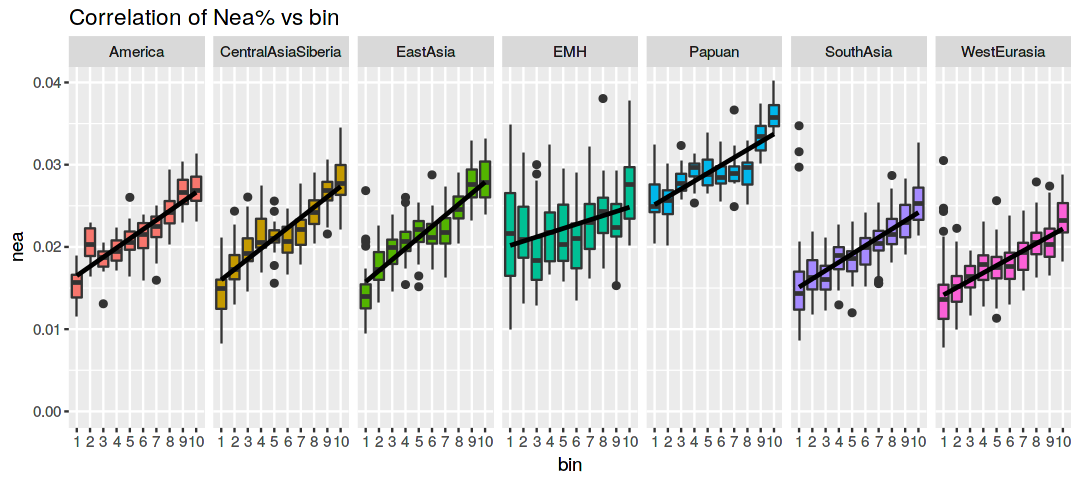

In [11]:
options(repr.plot.width=9, repr.plot.height=4)

# boxplots of Nea% per bin in each population
unnest(nea_bins, bins) %>% filter(pop != "Africa") %>%
  {
      ggplot(., aes(bin, nea, fill=pop, group=bin)) +
          geom_boxplot() +
          geom_smooth(method="lm", se=FALSE, color="black", aes(group=pop)) +
          coord_cartesian(ylim=c(0, 0.04)) +
          ggtitle(paste("Correlation of Nea% vs bin ")) +
          theme(legend.position="none") +
          facet_grid(. ~ pop)
  } %>% print

### Nea% in each bin aggregated by a population - per individual

### Nea% in each bin aggregated by a population - per individual

## Linear regression metrics

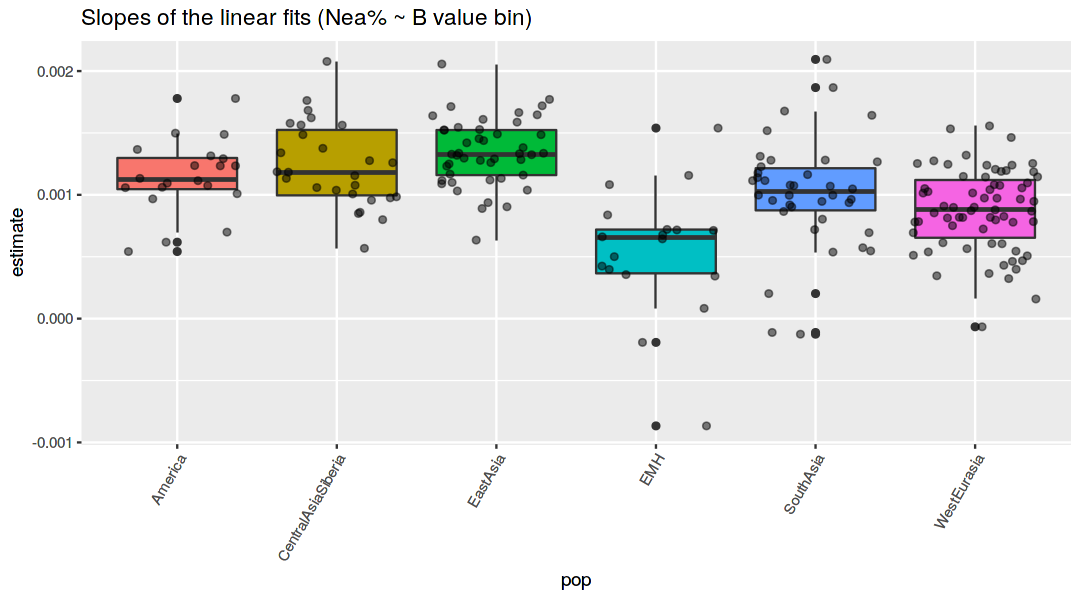

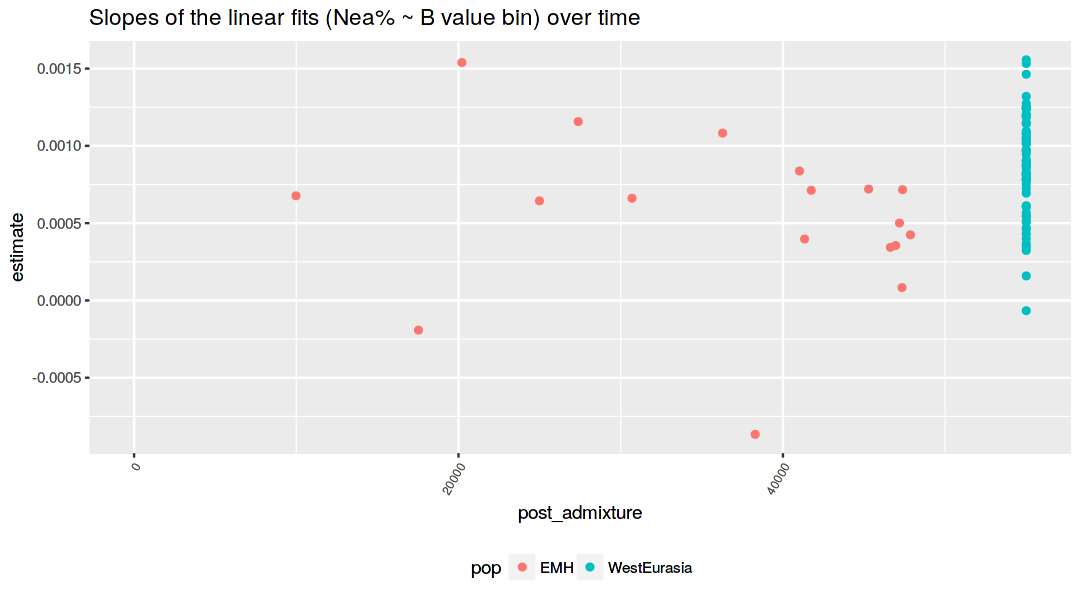

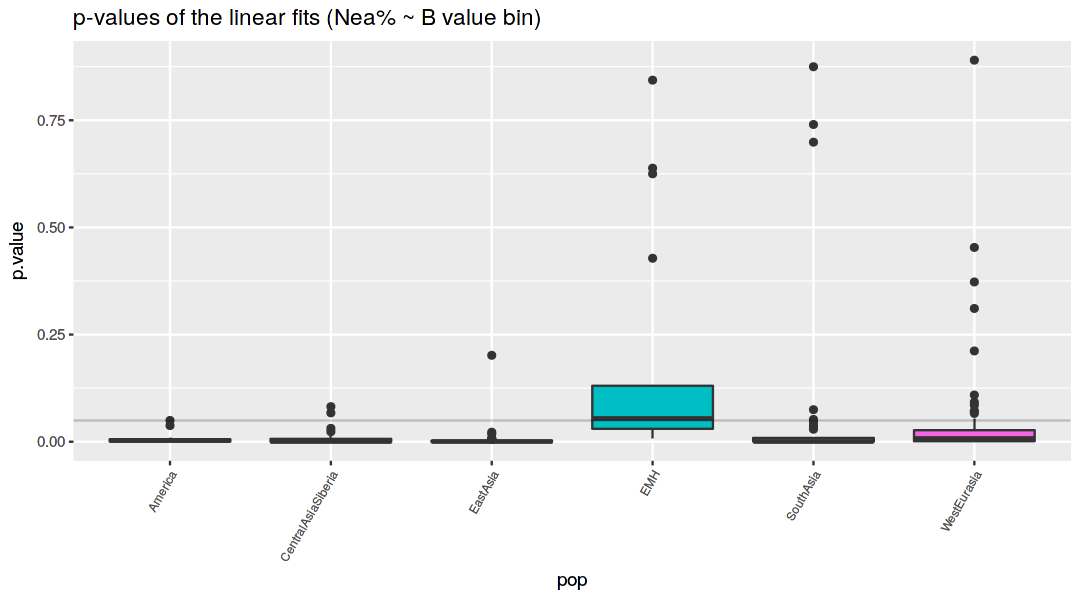

In [22]:
options(repr.plot.width=9, repr.plot.height=5)

nea_bin_lm <- function(df) {
  lm(nea ~ bin, data=mutate(df, bin=as.integer(bin)))
}

lm_per_sample <- nea_bins %>%
  unnest %>%
  filter(pop != "Africa") %>%
  group_by(name, pop, post_admixture) %>%
  nest %>%
  mutate(model=map(data, nea_bin_lm),
         glance=map(model, glance),
         tidy=map(model, tidy))

# plot the distribution of slopes in each pop
unnest(lm_per_sample, tidy) %>%
  filter(term == "bin") %>%
  ggplot(aes(pop, estimate, fill=pop)) +
  geom_boxplot() +
  geom_jitter(alpha=1/2) +
  ggtitle("Slopes of the linear fits (Nea% ~ B value bin)") +
  theme(axis.text.x=element_text(angle=60, hjust=1),
        legend.position="none")

# plot the slopes over time
unnest(lm_per_sample, tidy) %>%
  filter(term == "bin", pop == "EMH" | pop == "WestEurasia") %>%
  ggplot(aes(post_admixture, estimate, colour=pop)) +
  geom_point() +
  ggtitle("Slopes of the linear fits (Nea% ~ B value bin) over time") +
  theme(axis.text.x=element_text(angle=60, hjust=1, size=7),
        legend.position="bottom") +
  xlim(0, 55000)

# plot the p.value of each fit
unnest(lm_per_sample, glance, .drop=TRUE) %>%
  ggplot(aes(pop, p.value, fill=pop)) +
  geom_boxplot() +
  geom_hline(yintercept=0.05, alpha=1/5) +
  ggtitle("p-values of the linear fits (Nea% ~ B value bin)") +
  theme(axis.text.x=element_text(angle=60, hjust=1, size=7),
        legend.position="none")

In [13]:
library(maps)


Attaching package: 'maps'

The following object is masked from 'package:purrr':

    map



## Genome-wide Nea%

In [14]:
nea_est <- samples_info %>%
    mutate(nea=sapply(as.character(name), function(n) { calc_sharing_prop(all_snps, "archaic_Altai", n)}))

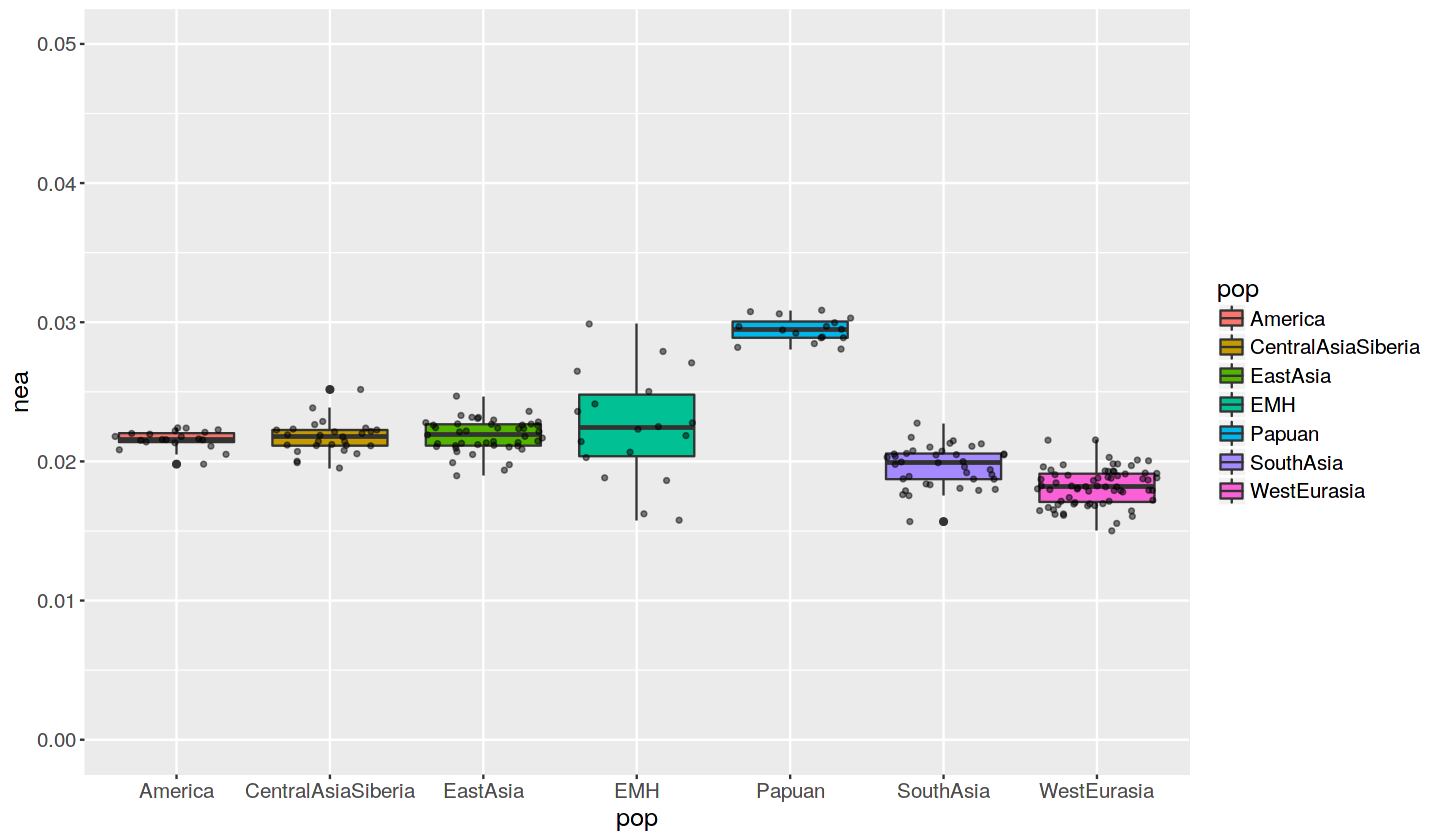

In [15]:
options(repr.plot.width=12, repr.plot.height=7)

filter(nea_est, pop != "Africa") %>%
ggplot() +
  geom_boxplot(aes(pop, nea, fill=pop)) +
  geom_jitter(aes(pop, nea), size=1, alpha=1/2) +
  coord_cartesian(ylim=c(0, 0.05)) +
  theme(text=element_text(size=15),
        legend.position="right")

In [16]:
head(nea_est)

name,age,pop,Country,Latitude,Longitude,post_admixture,nea
UstIshim,45020,EMH,NA,NA,NA,9980,0.02790194
Kostenki14,37470,EMH,NA,NA,NA,17530,0.02708133
GoyetQ116_1,34795,EMH,NA,NA,NA,20205,0.02987416
Vestonice16,30010,EMH,NA,NA,NA,24990,0.02647948
Ostuni1,27620,EMH,NA,NA,NA,27380,0.02249992
Malta1,24305,EMH,NA,NA,NA,30695,0.02231115


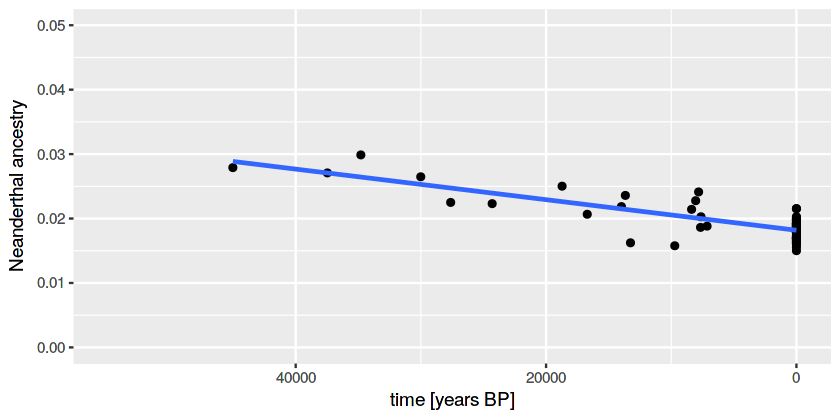

In [17]:
options(repr.plot.width=7, repr.plot.height=3.5)

filter(nea_est, pop %in% c("EMH", "WestEurasia")) %>%
    ggplot(aes(age, nea)) +
    geom_point() +
    geom_smooth(method="lm", se=FALSE) +
    ylim(0, 0.05) +
    scale_x_reverse(lim=c(55000, 0)) +
    labs(x="time [years BP]", y="Neanderthal ancestry")

Warning message:
"Removed 18 rows containing missing values (geom_point)."

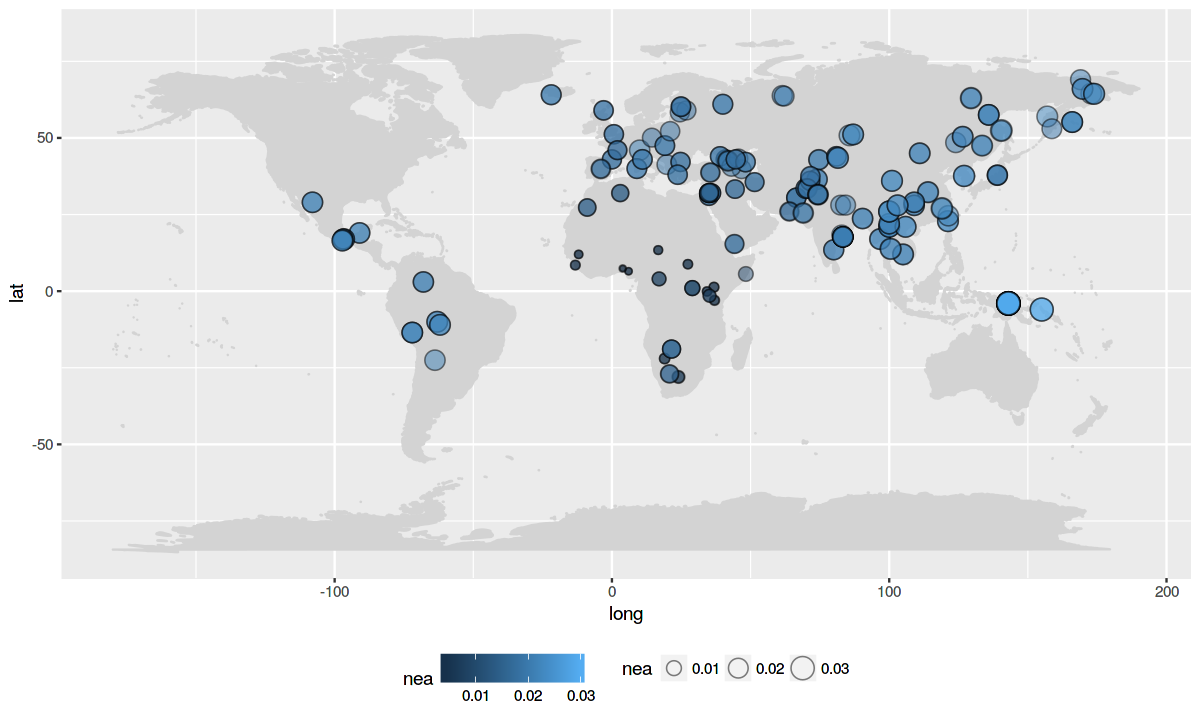

In [18]:
options(repr.plot.width=10, repr.plot.height=6)

map_plot <-
    map_data("world") %>%
    ggplot() +
    geom_polygon(aes(x=long, y=lat, group=group), 
                 colour="light gray", fill="light gray")

map_plot +
    geom_point(data=nea_est, 
               aes(Longitude, Latitude, fill=nea, size=nea), pch=21, alpha=1/2) +
    theme(legend.position="bottom")